In [132]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectPercentile 


In [44]:
# # Load Data from folds 1-4

# # Make sure the working directory is the same as the script

# files = glob.glob('negative_polarity/deceptive_from_MTurk/fold1/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold2/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold3/*.txt')
# files += glob.glob('negative_polarity/deceptive_from_MTurk/fold4/*.txt')


# deceptive = pd.DataFrame(columns=['text'])   
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             deceptive = pd.concat([deceptive, pd.DataFrame({'text': [text]})], ignore_index=True)


# files = glob.glob('negative_polarity/truthful_from_Web/fold1/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold2/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold3/*.txt')
# files += glob.glob('negative_polarity/truthful_from_Web/fold4/*.txt')

# truthful = pd.DataFrame(columns=['text'])
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             truthful = pd.concat([truthful, pd.DataFrame({'text': [text]})], ignore_index=True)

# deceptive['label'] = 0
# truthful['label'] = 1

# train = pd.concat([deceptive, truthful], ignore_index=True)

# files = glob.glob('negative_polarity/deceptive_from_MTurk/fold5/*.txt')
# deceptive_test = pd.DataFrame(columns=['text']) 
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             deceptive_test = pd.concat([deceptive_test, pd.DataFrame({'text': [text]})], ignore_index=True)


# files = glob.glob('negative_polarity/truthful_from_Web/fold5/*.txt')
# truthful_test = pd.DataFrame(columns=['text'])
# for file in files:
#     with open(file, 'r') as f:
#             text = f.read()
#             truthful_test = pd.concat([truthful_test, pd.DataFrame({'text': [text]})], ignore_index=True)

# deceptive_test['label'] = 0
# truthful_test['label'] = 1

# test = pd.concat([deceptive_test, truthful_test], ignore_index=True)



In [46]:
# train.to_csv('train.csv', index=False)
# test.to_csv('test.csv', index=False)

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### BOW Unigrams No Normalisation

In [130]:
# Bag of words with unigrams
text_clf = Pipeline([
    ('vect', CountVectorizer())
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']





In [131]:
# Create Models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Tune hyperparameters
param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_



Training Naive Bayes
Best parameters: {}
Best score: 0.8265625
Training Logistic Regression
Best parameters: {'C': 1}
Best score: 0.8484375
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.7078125
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1000}
Best score: 0.8453125


In [134]:
# Evaluate models
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)


                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.89375   0.909091  0.8750  0.891720
1  Logistic Regression   0.83125   0.797753  0.8875  0.840237
2        Decision Tree   0.64375   0.641975  0.6500  0.645963
3        Random Forest   0.84375   0.795699  0.9250  0.855491


In [135]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
         Feature  Importance
1193     chicago    0.036854
3631    location    0.015073
5564       smell    0.012157
4005          my    0.010640
2454     finally    0.009011
3696      luxury    0.008977
1699     decided    0.008737
6669         was    0.007825
3880  millennium    0.007460
5313      seemed    0.007330

Feature Importance: Decision Tree
          Feature  Importance
1193      chicago         1.0
0              00         0.0
4586          ppl         0.0
4597     prefered         0.0
4596   preferably         0.0
4595       prefer         0.0
4594  predicament         0.0
4593      precise         0.0
4592     precious         0.0
4591          pre         0.0


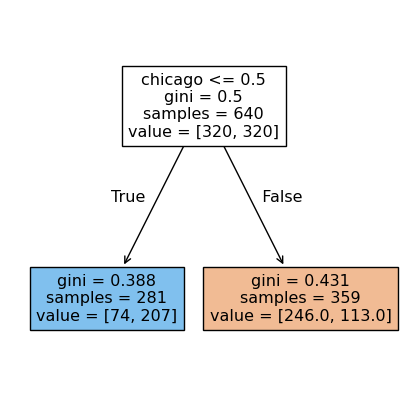

In [137]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW Unigrams with Normalisation and Feature Selection

In [183]:
# Bag of words with normalisation

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

selector = SelectPercentile(percentile=10)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]



In [184]:

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Tune hyperparameters

param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_



Training Naive Bayes
Best parameters: {}
Best score: 0.8859375
Training Logistic Regression
Best parameters: {'C': 10}
Best score: 0.9171875
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.725
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.865625


In [185]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)


                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.85000   0.900000  0.7875  0.840000
1  Logistic Regression   0.85625   0.820225  0.9125  0.863905
2        Decision Tree   0.63125   0.612903  0.7125  0.658960
3        Random Forest   0.78750   0.755556  0.8500  0.800000


In [186]:
# Get feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
      Feature  Importance
110   chicago    0.044875
234   finally    0.020933
386        my    0.019732
656       was    0.017139
548     smell    0.017019
339  location    0.015797
74         be    0.014820
317        is    0.013626
52         at    0.012439
600       the    0.011943

Feature Importance: Decision Tree
      Feature  Importance
110   chicago         1.0
463     quiet         0.0
455  properly         0.0
456  property         0.0
457      pros         0.0
458    public         0.0
459       put         0.0
460   putting         0.0
461    queens         0.0
462     quick         0.0


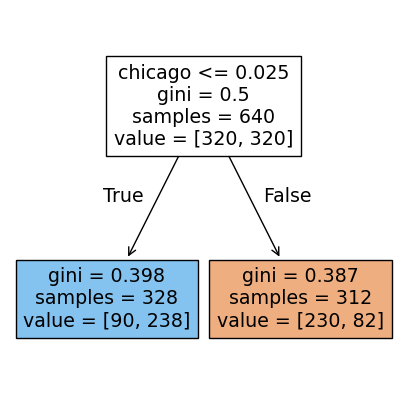

In [187]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW With Bigrams No Normalisation

In [153]:
# Bag of Words with bigrams

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2)))    
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

In [154]:
# Tune hyperparameters

param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_

Training Naive Bayes
Best parameters: {}
Best score: 0.8015625
Training Logistic Regression
Best parameters: {'C': 1}
Best score: 0.8515625
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.7078125
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1000}
Best score: 0.8328125


In [158]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)

                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.83750   0.921875  0.7375  0.819444
1  Logistic Regression   0.82500   0.788889  0.8875  0.835294
2        Decision Tree   0.64375   0.641975  0.6500  0.645963
3        Random Forest   0.83125   0.819277  0.8500  0.834356


In [159]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
            Feature  Importance
16968       finally    0.002177
26790      location    0.001783
9711        chicago    0.001564
41460         smell    0.001538
33109          open    0.001454
41487       smelled    0.001449
14951     elevators    0.001407
52744            we    0.001372
53821  when arrived    0.001368
15995      expected    0.001208

Feature Importance: Decision Tree
                     Feature  Importance
9711                 chicago         1.0
0                         00         0.0
37227  recently additionally         0.0
37216                 recent         0.0
37217        recent business         0.0
37218          recent family         0.0
37219      recent renovation         0.0
37220            recent stay         0.0
37221            recent syat         0.0
37222            recent trip         0.0


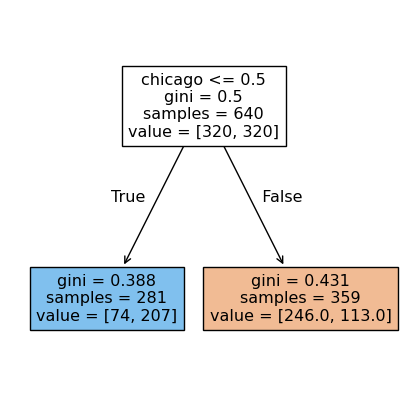

In [160]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()

### BOW Bigrams With Normalisation

In [216]:
# Bag of Words with vectorised bigrams

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer())  
])

X_train = text_clf.fit_transform(train['text'])
X_test = text_clf.transform(test['text'])

X_train = X_train.toarray()
X_test = X_test.toarray()

X_train = pd.DataFrame(X_train, columns=text_clf.named_steps['vect'].get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=text_clf.named_steps['vect'].get_feature_names_out())

y_train = train['label']
y_test = test['label']

selector = SelectPercentile(percentile=2)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

In [217]:
X_train.shape

(640, 1117)

In [220]:
# Tune hyperparameters

param_grid = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100, 250, 500]},
    'Decision Tree': {'max_depth': [1, 2, 5, 10, 100], 'ccp_alpha': [0.0, 0.1, 0.3, 0.5], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'max_depth': [1, 5, 10], 'n_estimators': [100, 1000], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5]}
}

for model_name, model in models.items():
    print(f'Training {model_name}')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    models[model_name] = grid_search.best_estimator_

Training Naive Bayes
Best parameters: {}
Best score: 0.9296875
Training Logistic Regression
Best parameters: {'C': 100}
Best score: 0.94375
Training Decision Tree
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 1, 'min_samples_split': 2}
Best score: 0.7171875
Training Random Forest
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1000}
Best score: 0.8609375


In [213]:
# Evaluate models

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    result = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'F1': [f1_score(y_test, y_pred)]
    })
    results = pd.concat([results, result], ignore_index=True)

print(results)

                 Model  Accuracy  Precision  Recall        F1
0          Naive Bayes   0.80625   0.888889  0.7000  0.783217
1  Logistic Regression   0.85625   0.843373  0.8750  0.858896
2        Decision Tree   0.64375   0.635294  0.6750  0.654545
3        Random Forest   0.82500   0.802326  0.8625  0.831325


In [214]:
# Feature importance
print('Feature Importance: Random Forest')
feature_importance_rf = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_rf['Feature'] = X_train.columns
feature_importance_rf['Importance'] = models['Random Forest'].feature_importances_
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_rf.head(10))

print('\nFeature Importance: Decision Tree')
feature_importance_dt = pd.DataFrame(columns=['Feature', 'Importance'])
feature_importance_dt['Feature'] = X_train.columns
feature_importance_dt['Importance'] = models['Decision Tree'].feature_importances_
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print(feature_importance_dt.head(10))

Feature Importance: Random Forest
       Feature  Importance
480    chicago    0.020768
259     at the    0.008903
2548       was    0.006947
1392        my    0.006313
251         at    0.006205
1289    luxury    0.006189
1751  recently    0.005808
315         be    0.005752
1966     smell    0.005748
2589   was not    0.005716

Feature Importance: Decision Tree
              Feature  Importance
480           chicago         1.0
1864            route         0.0
1856     room without         0.0
1857         room you         0.0
1858        rooms are         0.0
1859  rooms available         0.0
1860        rooms had         0.0
1861         rooms is         0.0
1862       rooms were         0.0
1863            rough         0.0


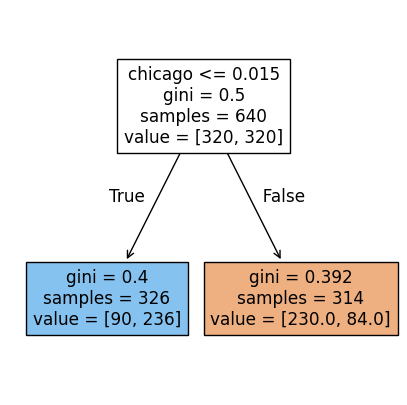

In [215]:
# Plot DT
plt.figure(figsize=(5, 5))
plot_tree(models['Decision Tree'], filled=True, feature_names=X_train.columns)
plt.show()